In [67]:
from IPython.display import Image


`Closest-Pair problem in 2d`: Given an array of 2d points, find the pair of points with the shortest (Euclidean or some other given metric) distance.

A `brute force` algorithm for solving this problem would be to compare the distance between every possible pair of points and find the pair which has the smallest distance. This would require O(n^2) operations.

A `more efficient` algorithm can be designed using a `divide and conquer` approach. In this algorithm, we first apply a pre-processing step in which we create two copies of the array, `P` and `Q`, and sort them in non-decreasing order of the x-cordinates and y-coordinates of the points respectively. Then we take the array P and partition it down the middle into sub-arrays `PL[0..n/2]` and `PR[n/2 +1..n-1]` and recursively find the closest pair of points in each partition, with distances `dL` and `dR` (the base case of the recursion occurs when we have sub-arrays of size <= 3 and we apply the brute force algorithm to find their closest pairs). Then we take the smaller of these two distances `d = min(dL, dR)`. Next we have to consider the possibility of closest-pairs consisting of one point from the left partition and one from the right. If such a pair exist, the horizintal distance between these two points must necessarily be less than `d` and so we only need to check the points that are contained within a vertical strip of width `2d` centered at the partition boundary (strip width is `2` times `d` because one of the points could lie directly on the partition boundary such that the other point could be a distance `<d` away from the partition boundary in either direction, see red points in the diagram below).

<img src="fig1.png" width="400" height="300">  

Next, we copy all the points from array `Q` which lie inside this strip into a new array `S` (so these points are already going to be sorted in the y-coordinate). Our goal now is to find the new closest pair from `S`, if it exists. We could do this in a brute force manner by checking the distance between all pairs of points in `S`. However, we also know that any pair of points from the same side on one-half of the strip cannot have a vertical separation less than `d`. So for any given point in S, we know that only need to check points that are within a vertical distance of `d` from it and within horizontal distance `2d` from it, and there can be at most 5 such points (because in a rectangle of width `2d` and height `d` withing the strip can contain at most 6 points, as illustrated in the diagram below):  

<img src="fig2.png" width="350" height="220">

Since the points in `S` are sorted in the y-coordinate, this then means that for each point in `S`, we would only need to check the next 5 points after it for a possible closest-pair. 

In [68]:
import math
import sys

def hoare_partition(A, lo, hi, c):
    i = lo+1
    j = hi
    p = A[lo][c]
    while True:
        #print(f"i = {i}, c = {c}, A[{i}, 0] = {A[i][0]}, A[{i}, 1] = {A[i][1]}")
        #print(f"lo = {lo}, hi = {hi}, p = {p}")
        while((A[i][c] <= p) and (i < hi)):
            #print(f"i = {i}")
            i += 1
        while((A[j][c] >= p) and (j > lo)):
            j-= 1 
        
        if (i >= j):
            break
        
        #print(f"i = {i}, j = {j}")
        #print(f"Before swap = {A}")
        
        temp = A[i]
        A[i] = A[j]
        A[j] = temp

        #print(f"After swap  = {A}")

    temp = A[j]
    A[j] = A[lo]
    A[lo] = temp
    return j

# modified quicksort for sorting list of tuples. c is the component of the tuple that will be used for the sorting order
def quick_sort(A, lo, hi, c):
    if(lo < hi):

        # apply Hoare partitioning
        s = hoare_partition(A, lo, hi, c)
        
        # recursively sort the left and right sub arrays
        quick_sort(A, lo, s-1, c)
        quick_sort(A, s+1, hi, c)

# recursive closest pair algorithm implementation
def closest_pair(A, lo, hi, first = False):

    # pre-processing step
    if(first):
        # sort the list of points in non-decreasing order of the x-co-ordinate
        quick_sort(A, 0, len(A)-1, 0)
        # sort in non-decreasing order of y-coordinate
        Q = A.copy()
        quick_sort(Q, 0, len(Q)-1, 1)
        first = False
        print(f"x-coordinate sorted points: {A}")
        print(f"y-coordinate sorted points: {Q}")
    
    # apply brute force algorithm for recursion base case
    if((hi-lo+1) <= 3):
        return closest_pair_brute(A, lo, hi)
    
    else:
        # recursilvely call left and right sub parts
        mid = lo + math.floor((hi-lo)/2)    
        p1_L, p2_L = closest_pair(A, lo, mid, first)    
        p1_R, p2_R = closest_pair(A, mid+1, hi, first) 

        print(f"lo = {lo}, hi = {hi}, mid = {mid}")

        if(dist(p1_L, p2_L) <= dist(p1_R, p2_R)):
            p1, p2 =  p1_L, p2_L
            dmin = dist(p1_L, p2_L) 
        else:
            p1, p2 =  p1_R, p2_R
            dmin = dist(p1_R, p2_R) 
         
        print(f"Current closest pair: {p1}, {p2}")

        # x-coordinate of median line separating left and right partitions
        m = A[mid][0]

        print(f"m = {m}, dmin = {dmin}")

        # re-sort the list of points in non-decreasing order of the y-co-ordinate
        Q = A.copy() 
        quick_sort(Q, 0, len(Q)-1, 1)
       
        # copy all points that lie withing the strip of width 2*dmin centered around m from the y-cordinate sorted list 
        S= []
        for i in range(len(Q)):
            if(abs(Q[i][0]-m) < dmin):
                S.append(Q[i])

        print(f"Points inside strip around median: {S}")

        # find closest pair of points within the strip with distance smaller than the current known closest pair
        for i in range(len(S)-2):
            #k = i+1
            #while((k <= len(S)-1) and ((S[i][1]-S[k][1])**2 < dmin)):
            # need to compare each point in strip with at most next 5 points
            for k in range(i+1, min(i+5, len(S)-1)):
                d = dist(S[i], S[k])
                if(d <= dmin):
                    p1, p2 = S[i], S[k]
                    dmin = d
                    print(f"New closest pair found: {S[i]}, {S[k]}")
                k += 1

        return p1, p2

# closest pair problem brute-force algorithm
def closest_pair_brute(A, lo, hi):

    if((hi-lo+1) == 2):
        return A[lo], A[lo+1] 

    else:
        d = sys.float_info.max
        for i in range(lo, hi):
           for j in range(i+1, hi+1):
               if(dist(A[i], A[j]) <= d):
                   d = dist(A[i], A[j])
                   p1 = A[i]
                   p2 = A[j]

        return p1, p2


# square of euclidean distanced between two points in 2d 
def dist(p1, p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)


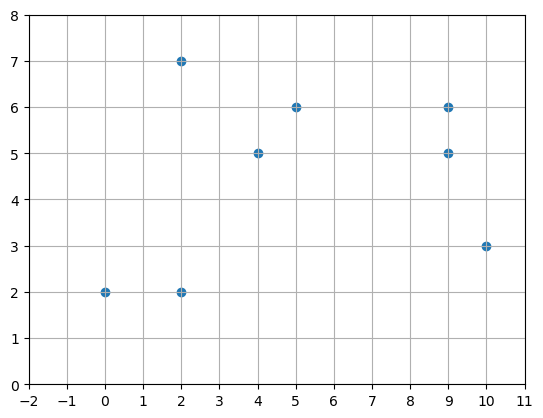

x-coordinate sorted points: [(0, 2), (2, 2), (2, 7), (4, 5), (5, 6), (9, 6), (9, 5), (10, 3)]
y-coordinate sorted points: [(0, 2), (2, 2), (10, 3), (4, 5), (9, 5), (9, 6), (5, 6), (2, 7)]
lo = 0, hi = 3, mid = 1
Current closest pair: (0, 2), (2, 2)
m = 2, dmin = 4
Points inside strip around median: [(0, 2), (2, 2), (4, 5), (5, 6), (2, 7)]
New closest pair found: (0, 2), (2, 2)
New closest pair found: (4, 5), (5, 6)
lo = 4, hi = 7, mid = 5
Current closest pair: (9, 5), (10, 3)
m = 9, dmin = 5
Points inside strip around median: [(10, 3), (9, 5), (9, 6), (5, 6)]
New closest pair found: (10, 3), (9, 5)
New closest pair found: (9, 5), (9, 6)
lo = 0, hi = 7, mid = 3
Current closest pair: (9, 5), (9, 6)
m = 4, dmin = 1
Points inside strip around median: [(4, 5)]
((9, 5), (9, 6))


In [69]:
import matplotlib.pyplot as plt
import numpy as np

# test points
A = [(0,2),(4,5),(2,7),(9,6),(2,2),(10,3),(5,6), (9,5)]


x = [p[0] for p in A]
y = [p[1] for p in A]

plt.scatter(x,y)
plt.xticks(np.arange(min(x)-2, max(x)+2, 1))
plt.yticks(np.arange(min(y)-2, max(y)+2, 1))
plt.grid()
plt.show()

print(closest_pair(A, 0 , len(A)-1, True))
